In [74]:
import json
import pandas as pd

with open('arousal_scores_output.json', 'r') as f:
    arousal_scores = json.load(f)
    
df = pd.DataFrame(arousal_scores)
df

# Function to extract adjectives from the string
def extract_adjectives(adj_str):
    try:
        # Remove json code blocks if present
        adj_str = adj_str.replace('```json\n', '').replace('\n```', '')
        # Convert string to list using json.loads
        adj_list = json.loads(adj_str)
        return adj_list
    except:
        return []

# Apply the function to extract adjectives
df['adjectives'] = df['arousal_scores'].apply(
    lambda x: [extract_adjectives(item['adjectives']) for item in x]
)

# Load ground truth data
with open('../datasets/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
# Convert ground truth to DataFrame
gt_df = pd.DataFrame(ground_truth)

# Merge with arousal scores DataFrame on narrative_id
df = df.merge(gt_df[['narrative_id', 'synopsis']], on='narrative_id', how='left')

# Load NRC VAD lexicon
with open('../nrc_vad.json', 'r') as f:
    nrc_vad = json.load(f)

# Function to get arousal score for a word
def get_arousal_score(word):
    return nrc_vad.get(word.lower(), {'arousal': 0.0})['arousal']

# Function to map adjectives to arousal scores
def map_adjectives_to_arousal(adj_lists):
    arousal_scores = [[get_arousal_score(adj) for adj in adj_list] for adj_list in adj_lists]
    return [round(sum(scores)/len(scores), 2) if scores else 0.0 for scores in arousal_scores]

# Map adjectives to arousal scores
df['arousal_values'] = df['adjectives'].apply(map_adjectives_to_arousal)

df

# Drop all columns except narrative_id and arousal_values
df = df[['narrative_id', 'arousal_values']]
# Save DataFrame to pickle file
df.to_pickle('arousal_score.pkl')





In [75]:
# Load ground truth data again to get source column
with open('../datasets/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
# Convert ground truth to DataFrame 
gt_df = pd.DataFrame(ground_truth)

# Merge with arousal scores DataFrame on narrative_id to add source column and synopsis
df = df.merge(gt_df[['narrative_id', 'source', 'synopsis']], on='narrative_id', how='left')

# Calculate synopsis length
df['synopsis_len'] = df['synopsis'].str.len()

# Display the DataFrame

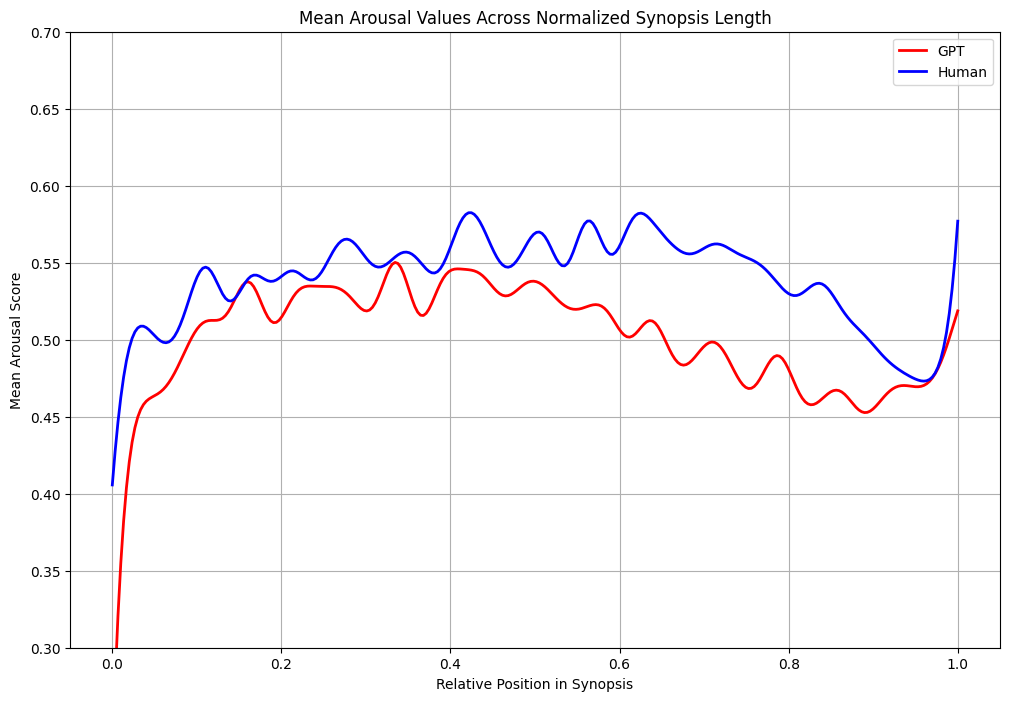

In [76]:
df

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

plt.figure(figsize=(12, 8))

# Define colors for each source
colors = {'GPT': 'red', 'Human': 'blue'}

# Create bins for normalized positions
num_bins = 40
bin_edges = np.linspace(0, 1, num_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initialize columns for binned values
for i in range(num_bins):
    df[f'arousal_bin_{i}'] = 0.0

# Calculate mean curves for each source and save binned values
for source in ['GPT', 'Human']:
    source_data = df[df['source'] == source]
    
    # Initialize array to store values for each bin
    binned_values = [[] for _ in range(num_bins)]
    
    # Collect values for each bin
    for idx, row in source_data.iterrows():
        arousal_values = row['arousal_values']
        synopsis_len = row['synopsis_len']
        x_coords = np.array([i/synopsis_len for i in range(len(arousal_values))])
        
        # Assign values to bins and save to DataFrame
        for i, (left, right) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
            mask = (x_coords >= left) & (x_coords < right)
            if any(mask):
                bin_values = np.array(arousal_values)[mask]
                binned_values[i].extend(bin_values)
                df.at[idx, f'arousal_bin_{i}'] = np.mean(bin_values)
    
    # Calculate mean for each bin
    mean_curve = [np.mean(bin_vals) if bin_vals else 0 for bin_vals in binned_values]
    
    # Create smooth curve using B-spline interpolation
    spl = make_interp_spline(bin_centers, mean_curve, k=5)
    x_smooth = np.linspace(0, 1, 300)
    y_smooth = spl(x_smooth)
    
    # Plot the smoothed curve
    plt.plot(x_smooth, y_smooth, color=colors[source], label=source, linewidth=2)

plt.legend()
plt.xlabel('Relative Position in Synopsis')
plt.ylabel('Mean Arousal Score')
plt.title('Mean Arousal Values Across Normalized Synopsis Length')
plt.ylim(0.3, 0.7)
plt.grid(True)
plt.show()


In [77]:
df

,narrative_id,arousal_values,source,synopsis,synopsis_len,arousal_bin_0,arousal_bin_1,arousal_bin_2,arousal_bin_3,arousal_bin_4,...,arousal_bin_30,arousal_bin_31,arousal_bin_32,arousal_bin_33,arousal_bin_34,arousal_bin_35,arousal_bin_36,arousal_bin_37,arousal_bin_38,arousal_bin_39
0,54868396,"[0.37, 0.25, 0.51, 0.44, 0.44, 0.38, 0.38, 0.4...",GPT,"[George Lawson, a man of 70 years with a rich ...",30,0.370,0.25,0.510,0.00,0.44,...,0.33,0.00,0.550,0.46,0.65,0.00,0.37,0.400,0.380,0.00
1,66494833,"[0.45, 0.74, 0.63, 0.61, 0.51, 0.51, 0.67, 0.5...",Human,[An old man conducts a ritual by slaughtering ...,61,0.595,0.62,0.510,0.59,0.52,...,0.61,0.41,0.625,0.68,0.61,0.61,0.58,0.640,0.765,0.72
2,31643609,"[0.47, 0.61, 0.49, 0.43, 0.51, 0.4, 0.61, 0.67...",GPT,"[Jane Thompson, a woman nurtured by resilience...",41,0.540,0.49,0.430,0.51,0.40,...,0.55,0.49,0.560,0.38,0.80,0.64,0.38,0.260,0.480,0.46
3,71399138,"[0.57, 0.67, 0.27, 0.69, 0.62, 0.86, 0.79, 0.6...",Human,[Tess Marshall arrives at a rental house in th...,35,0.570,0.67,0.270,0.69,0.62,...,0.61,0.00,0.360,0.81,0.90,0.84,0.59,0.790,0.420,0.00
4,92861580,"[0.0, 0.59, 0.13, 0.7, 0.51, 0.51, 0.72, 0.64,...",GPT,"[The film opens with the robust, comforting vo...",42,0.295,0.13,0.700,0.51,0.51,...,0.48,0.35,0.590,0.46,0.40,0.36,0.56,0.450,0.260,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,51944553,"[0.0, 0.0, 0.38, 0.0, 0.7, 0.0, 0.56, 0.68, 0....",GPT,"[In the vast cosmos, a massive floating comple...",40,0.000,0.00,0.190,0.00,0.70,...,0.63,0.56,0.565,0.46,0.00,0.42,0.56,0.465,0.550,0.00
435,19348137,"[0.0, 0.51, 0.57, 0.54, 0.41, 0.72, 0.68, 0.75...",GPT,"[Our narrative unfolds with Tom Fisher, a worl...",37,0.000,0.51,0.570,0.54,0.41,...,0.55,0.42,0.390,0.32,0.36,0.32,0.43,0.320,0.320,0.00
436,52371,"[0.0, 0.0, 0.0, 0.46, 0.21, 0.35, 0.68, 0.41, ...",Human,"[In 1996, treasure hunter Brock Lovett and his...",42,0.000,0.00,0.460,0.21,0.35,...,0.56,0.36,0.370,0.56,0.47,0.36,0.23,0.480,0.450,0.60
437,50214300,"[0.39, 0.05, 0.28, 0.31, 0.34, 0.58, 0.46, 0.3...",GPT,"[John and Casper are twin siblings, gifted wit...",54,0.220,0.28,0.325,0.58,0.46,...,0.65,0.64,0.450,0.49,0.58,0.30,0.48,0.435,0.310,0.50


In [73]:
df

df.to_pickle('./arousal_binned.pkl')
